In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlalchemy  
from urllib.parse import quote_plus
import plotly.graph_objects as go

In [2]:
# IMPORT FILE .
file_path = '/my/file/path/social_media_engagement.csv'
social_engagement = pd.read_csv(file_path)
social = pd.DataFrame(social_engagement)

# DROP COLUMN 'Campaign ID' , 'Influencer ID' and rename 'Engagement Rate'
social.drop(['Campaign ID' , 'Influencer ID'], axis = 1, inplace=True ) 
social.rename(columns = { ' Engagement Rate ' : 'Engagement Rate' } , inplace = True )

# split date column to date and day_of_week .
date_and_day = social['Date'].str.split('(', expand=True)

social['Date'] = date_and_day[0].str.strip()

social['day_of_week'] = date_and_day[1].str.strip(')')

social['Date'] = pd.to_datetime(social['Date'])

social.insert(6, 'day_of_week', social.pop('day_of_week'))

In [3]:
db_user = 'postgres'
db_password = 'db_password'
db_host = 'localhost'
db_name = 'social_engagement'

# Encode the password
encoded_password = quote_plus(db_password)

# Construct the database URL
db_url = f'postgresql://{db_user}:{encoded_password}@{db_host}/{db_name}'

engine = sqlalchemy.create_engine(db_url)

# THIS FUNCTION WILL CREATE A DATABASE IN POSTGRES RDBMS 
def load_data(df, table_name, engine):
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

# create a database in postgres
load_data(social, 'social', engine)

In [4]:
pd.read_sql_query(" SELECT * FROM social limit 2", engine )

,Platform,Post ID,Post Type,Post Content,Post Timestamp,Date,day_of_week,Weekday Type,Time,Time Periods,...,Impressions,Reach,Engagement Rate,Audience Age,Age Group,Audience Gender,Audience Location,Audience Continent,Audience Interests,Sentiment
0,Instagram,16ce29c5-2dc7-478f-9814-a86754f3ce8b,Video,Increase fast partner south.,07/30/23 06:40 AM,2023-07-30,Sunday,Weekend,6:40:06,Morning,...,3884,1223,91.41,48,Senior Adults,Male,Greece,Europe,population,Neutral
1,Facebook,a30c948b-0fb3-4e92-95da-e2dea184f568,Link,Floor glass bring indicate seem detail.,06/19/22 02:15 PM,2022-06-19,Sunday,Weekend,14:15:59,Afternoon,...,1831,1386,45.82,33,Mature Adults,Female,Lao People's Democratic Republic,Asia,attorney,Mixed


In [67]:
pd.read_sql_query(""" SELECT COUNT (DISTINCT "Post ID") as "Distinct Post ID" from social """ , engine)

,Distinct Post ID
0,100000


&nbsp;
&nbsp;

#### Engagement distribution by Platform

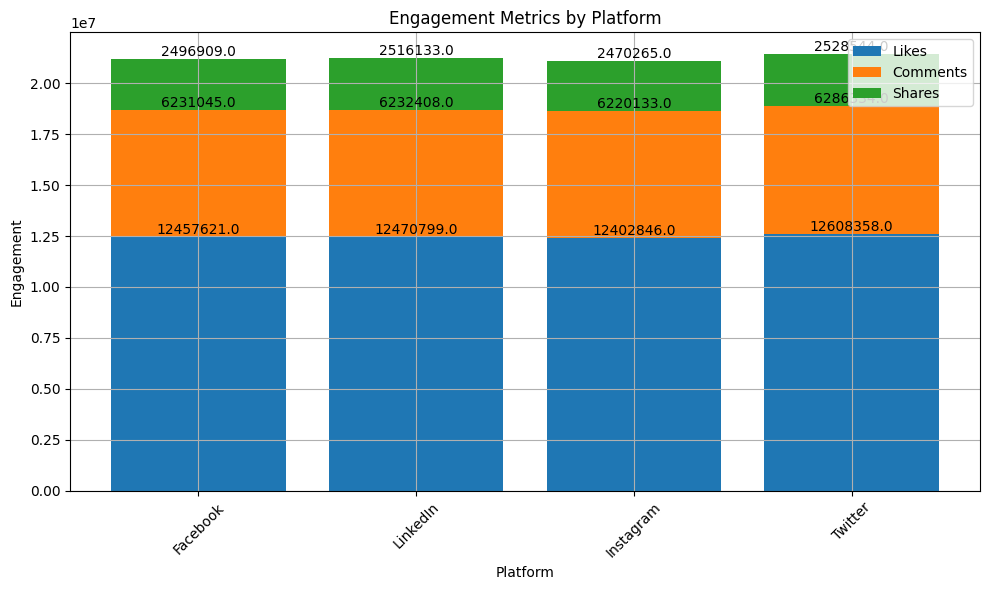

In [7]:
# SQL query to aggregate engagement metrics for each platform
query = """
    SELECT "Platform", 
           SUM("Likes" + "Comments" + "Shares") as "Total Engagement",
           SUM("Likes") as "Total Likes",
           SUM("Comments") as "Total Comments",
           SUM("Shares") as "Total Shares"
    FROM social
    GROUP BY "Platform"
"""

# Read data from the database using the SQL query
df = pd.read_sql_query(query, engine)

plt.figure(figsize=(10, 6))

# Plot stacked bar chart for engagement metrics by platform
likes_bar = plt.bar(df["Platform"], df["Total Likes"], label="Likes")
comments_bar = plt.bar(df["Platform"], df["Total Comments"], bottom=df["Total Likes"], label="Comments")
shares_bar = plt.bar(df["Platform"], df["Total Shares"], bottom=df["Total Likes"] + df["Total Comments"], label="Shares")

plt.xlabel('Platform')
plt.ylabel('Engagement')
plt.title('Engagement Metrics by Platform')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

# Add text labels to each bar
for likes, comments, shares in zip(likes_bar, comments_bar, shares_bar):
    x = likes.get_x() + likes.get_width() / 2
    y_likes = likes.get_height()
    y_comments = comments.get_height()
    y_shares = shares.get_height()
    
    plt.text(x, y_likes, round(y_likes, 2), ha='center', va='bottom')
    plt.text(x, y_likes + y_comments, round(y_comments, 2), ha='center', va='bottom')
    plt.text(x, y_likes + y_comments + y_shares, round(y_shares, 2), ha='center', va='bottom')

plt.show()


&nbsp;
&nbsp;

### Engagement trend over time 

In [211]:
pd.read_sql_query("""
                        select to_char("Date", 'YYYY') as "Year_quarter" , 
	       sum("Likes"+ "Comments" + "Shares")  as "Total Engagement", 
            sum("Impressions") as "Total Impression",
	sum("Reach") as "Total reach"
            from social 
		where to_char("Date", 'YYYY') < '2024'
            group by 1
            order by 4 asc
                        """, engine)

,Year_quarter,Total Engagement,Total Impression,Total reach
0,2021,22975973.0,156214908.0,67499232.0
1,2022,28210442.0,191057316.0,82473416.0
2,2023,28435033.0,192234264.0,83247339.0


&nbsp;
&nbsp;

### Empression outnumbered

In [70]:
pd.read_sql_query("""
                    SELECT "Platform" , "Total Impressions" , "Total Reach" , "Total Impressions" - "Total Reach" as "Empression outnumbered"
                 from (
                    select "Platform" , sum("Impressions") as "Total Impressions" , sum("Reach") as "Total Reach"
                    from social 
                    group by "Platform") as    t
                    order by "Total Reach" desc
                    """, engine)

,Platform,Total Impressions,Total Reach,Empression outnumbered
0,Twitter,144597998.0,62617016.0,81980982.0
1,LinkedIn,144683946.0,62281154.0,82402792.0
2,Facebook,143507500.0,62013527.0,81493973.0
3,Instagram,142477819.0,61735944.0,80741875.0


- **LinkedIn Effectiveness**: LinkedIn emerges as a potent platform for content distribution, particularly due to its exceptional visibility. This is evidenced by its ability to generate a substantial number of impressions relative to its reach metrics.

- **Twitter's Reach Dominance**: Twitter stands out for its remarkable reach metrics, indicating that content posted on this platform reaches the largest number of unique users compared to other platforms.

- **Efficiency Consideration**: With a lower "Impression outnumbered" value, Twitter appears to be more efficient in reaching a larger proportion of its audience compared to other platforms. This suggests that content on Twitter may have a higher engagement rate per impression.


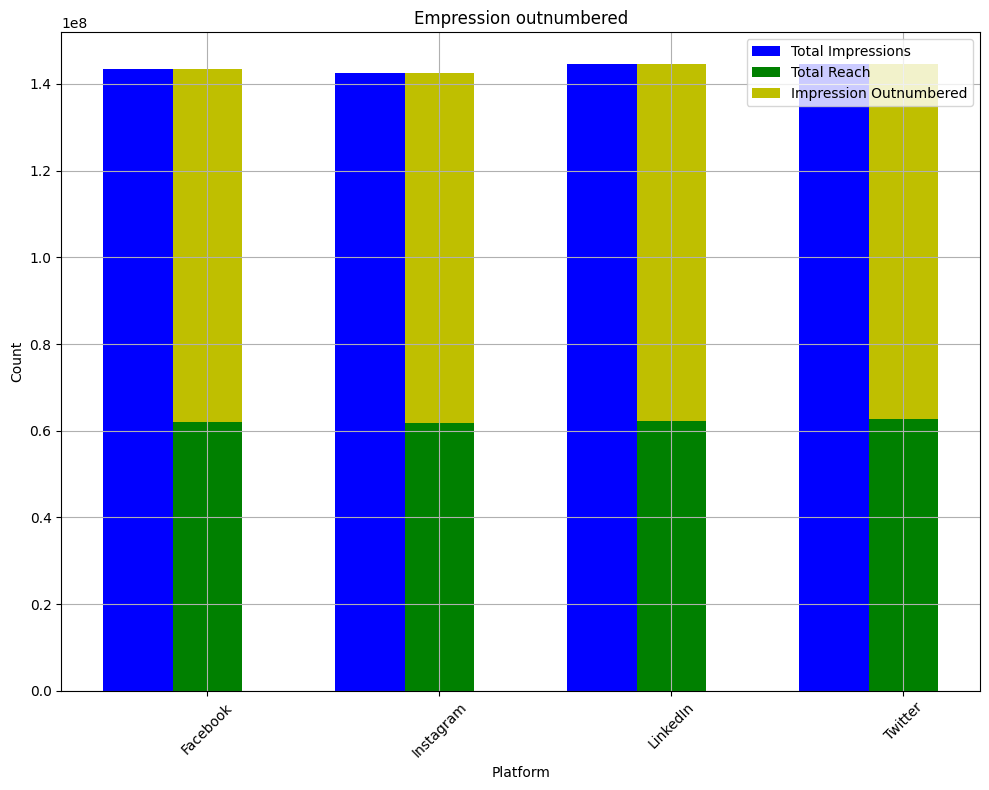

In [89]:

query = """
    SELECT "Platform", 
           SUM("Impressions") as "Total Impressions", 
           SUM("Reach") as "Total Reach", 
           (SUM("Impressions") - SUM("Reach")) as "Impression Outnumbered"
    FROM social
    GROUP BY "Platform"
"""

# Execute the query and read the results into a DataFrame
df = pd.read_sql_query(query, engine)

plt.figure(figsize=(10, 8))

bar_width = 0.3

# Create an array of x positions for each group of bars
x = np.arange(len(df['Platform']))

# Bar for Total Impressions
plt.bar(x - bar_width, df['Total Impressions'], color='b', width=bar_width, label='Total Impressions')

# Stacked bars for Total Reach and Impression Outnumbered
plt.bar(x, df['Total Reach'], color='g', width=bar_width, label='Total Reach')
plt.bar(x, df['Impression Outnumbered'], bottom=df['Total Reach'], color='y', width=bar_width, label='Impression Outnumbered')

# Labels and legend
plt.xlabel('Platform')
plt.ylabel('Count')
plt.title('Empression outnumbered')
plt.xticks(x, df['Platform'], rotation=45)
plt.legend()
plt.grid(True)
# Show plot
plt.tight_layout()
plt.show()


### Reason for Impressions Outnumbered
- Indicates that the content is being displayed multiple times to the same users or to a broad audience but is not necessarily reaching a large number of unique users, leading to repeated exposures without reaching new users.
- Content may not be reaching its intended audience or may not be capturing the attention of users effectively, resulting in wasted impressions and potentially higher advertising costs without proportional returns.
- **Action:** By addressing these potential inefficiencies, you can enhance the effectiveness of your content campaigns, improve audience engagement, and ultimately achieve better results in terms of reach and impact.


&nbsp;
&nbsp;


#### Analysis of Engagement, Reach, and Impressions by Post Type

In [236]:
pd.read_sql_query("""
                SELECT "Post Type", sum("Impressions") as "Total Impressions", sum("Likes" + "Comments" + "Shares") as "Total Engagement" ,
                 sum("Reach") as "Total Reach"
                from social
                group by "Post Type"
                order by 2 desc
                  """ , engine)

,Post Type,Total Impressions,Total Engagement,Total Reach
0,Video,192401531.0,28388809.0,83052530.0
1,Link,192029230.0,28326405.0,82957410.0
2,Image,190836502.0,28206181.0,82637701.0


&nbsp;
&nbsp;


[0 1 2]


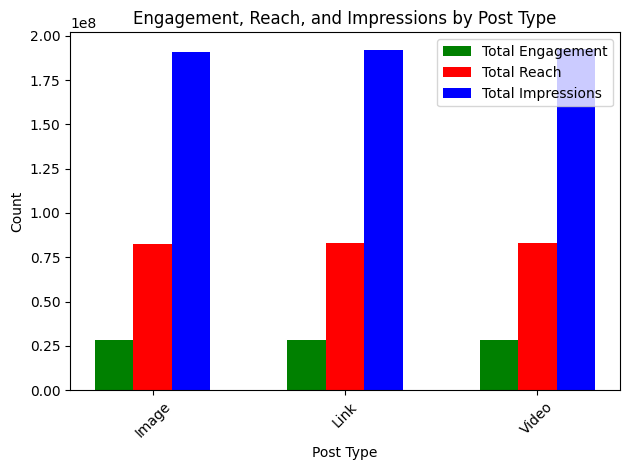

In [91]:
query = """
                SELECT "Post Type",  sum("Impressions") as "Total Impressions", sum("Likes" + "Comments" + "Shares") as "Total Engagement" ,
                 sum("Reach") as "Total Reach"
                from social
                group by "Post Type"
                  """

df =pd.read_sql_query(query, engine)
bar_width = 0.2
x = np.arange(len(df['Post Type']))
print(x)

plt.bar(x- bar_width , df['Total Engagement'] , width = bar_width , color = 'g' , label = 'Total Engagement' )

plt.bar(x , df['Total Reach'] , width = bar_width , color = 'r' , label = 'Total Reach' )
plt.bar(x + bar_width , df['Total Impressions'] , width = bar_width , color = 'b' , label = 'Total Impressions' )

plt.xlabel('Post Type')
plt.ylabel('Count')
plt.title('Engagement, Reach, and Impressions by Post Type')
plt.xticks(x, df['Post Type'], rotation=45)
plt.legend()
    
# Show plot
plt.tight_layout()
plt.show()

#### The "Video" post type has the highest total impressions, engagement, and reach among the three types.

&nbsp;
&nbsp;


&nbsp;
&nbsp;

### Average Engagement rate across different Platform

In [78]:
pd.read_sql_query(""" SELECT "Platform", 
                        avg("Engagement Rate") as "average engagement rate",
                        avg("Impressions") as "Average Impressions"
                        FROM social
                        group by "Platform"
                        order by 3 desc
                        """, engine )

,Platform,average engagement rate,Average Impressions
0,Facebook,46.910505,5768.218176
1,LinkedIn,46.725043,5758.335827
2,Twitter,46.918246,5747.138235
3,Instagram,47.125054,5736.976807


[0 1 2 3]


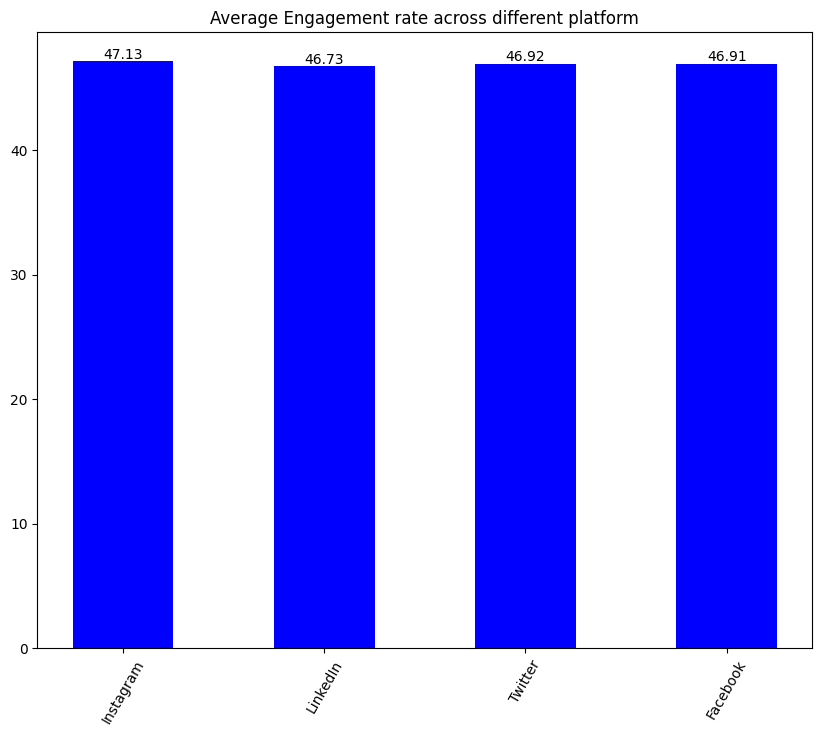

In [15]:
query = """ SELECT "Platform", avg("Engagement Rate") as "average engagement rate"
                        FROM social
                        group by "Platform"
                        """
df =  pd.read_sql_query(query, engine)

plt.figure(figsize=(10, 8))
bin_width = 0.5
x = np.arange(len(df["Platform"]))
print(x)

plt.bar(x, df["average engagement rate"], width = bin_width, color='b')
plt.title("Average Engagement rate across different platform")

for i ,value in enumerate(df['average engagement rate']):
    plt.text(x[i] , value , str(round(value, 2)) , va='bottom' , ha='center')

plt.xticks(x, df['Platform'], rotation=60)
plt.show()

#### This indicates that, on average, posts across different platforms receive a similar level of engagement, with an average engagement rate of around 46%. 

&nbsp;
&nbsp;

### Engagement Rate by "Age Group"

In [92]:
pd.read_sql_query(""" SELECT "Age Group", 
                	round(100 * sum("Total Likes" + "Total Comments" + "Total Shares")/ sum("Total Reach"), 2) as "Engagement Rate " ,
                	sum("Total Impressions") as "Total Impressions"
                    FROM 
                    (
                      SELECT  "Age Group", 
                      sum("Comments") as "Total Comments" ,
                      sum("Likes") as "Total Likes" , 
                      sum("Shares")  as "Total Shares" , 
                      sum("Reach") as "Total Reach" , 
                      sum("Impressions") as "Total Impressions"
                      FROM social group by 1
                	  ) as c
                     group by "Age Group"
                     order by "Total Impressions" desc
                        """, engine )

,Age Group,Engagement Rate,Total Impressions
0,Senior Adults,34.22,240104417.0
1,Mature Adults,34.04,179951923.0
2,Adolescent Adults,34.19,155210923.0


#### Senior Adults have the highest engagement rate at 34.22%, indicating active interaction with content relative to their reach. They also lead in total impressions, suggesting their substantial presence in engagement and exposure.

&nbsp;
&nbsp;

#### Engagement Rate for different Time Periods

In [87]:
pd.read_sql_query(("""  SELECT "Time Periods" ,
                        "Platform",
                        round(100 * (sum("Total Comments" + "Total Likes" + "Total Shares") / sum("Total Reach")), 2)  as engagement_rate,
                        sum("Total Impressions") as "Total Impressions"
                        FROM
                        (
                        SELECT "Time Periods" , 
                        "Platform",sum("Likes") as "Total Likes" , 
                        sum("Comments") as "Total Comments", 
                        sum("Impressions") as "Total Impressions",
                        sum("Shares") as "Total Shares", sum("Reach") as "Total Reach"
                        FROM social 
                        group by 1, 2
                        	) as c
                        group by "Time Periods", "Platform"
                        order by  "Platform" asc, "Total Impressions" desc
                        ;


                        """), engine )

,Time Periods,Platform,engagement_rate,Total Impressions
0,Night,Facebook,34.02,47808660.0
1,Morning,Facebook,33.91,36210485.0
2,Afternoon,Facebook,34.52,36028508.0
3,Evening,Facebook,34.29,23459847.0
4,Night,Instagram,34.13,47125505.0
5,Afternoon,Instagram,34.25,35749704.0
6,Morning,Instagram,34.12,35557100.0
7,Evening,Instagram,34.19,24045510.0
8,Night,LinkedIn,34.19,48049736.0
9,Morning,LinkedIn,34.15,36485224.0


#### Varies across platforms and time periods, with the highest impressions generally observed during the Night time period across all             platforms.

&nbsp;
&nbsp;

#### Number of Social Media Posts by Year-Quarter

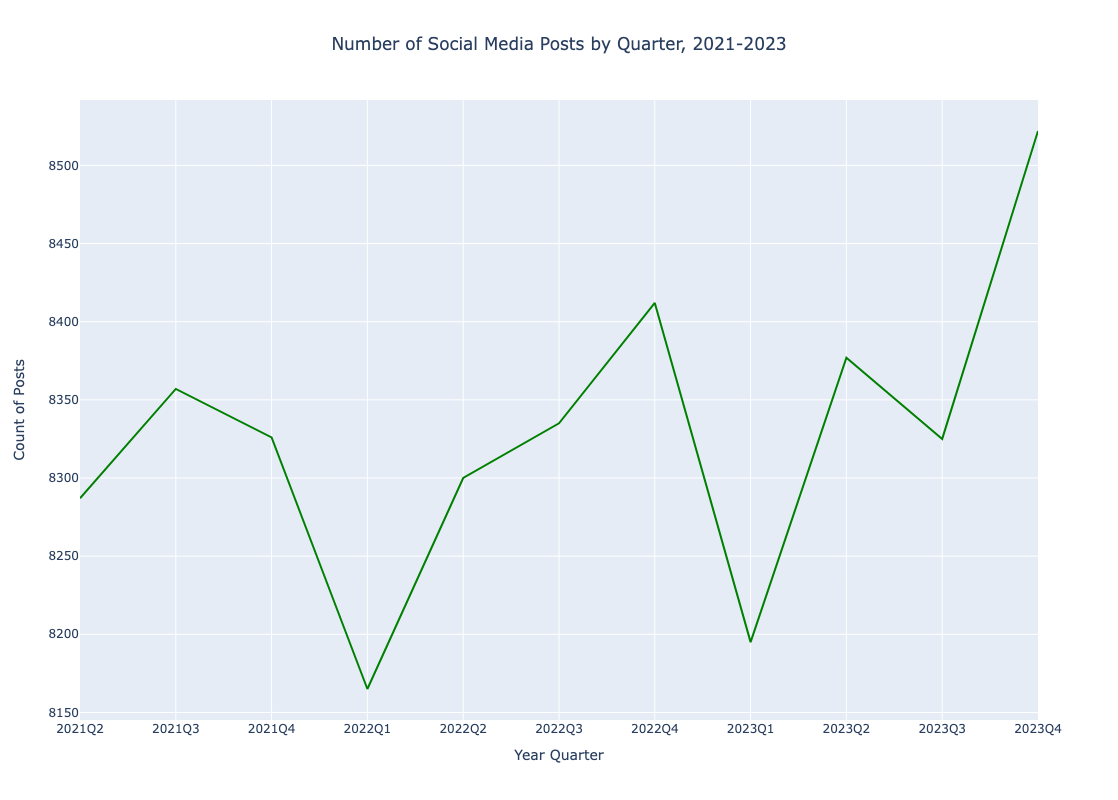

In [86]:
# Query to retrieve data from the database
query = """
    SELECT 
        TO_CHAR(date_trunc('quarter', "Date"), 'YYYY') || 'Q' || 
        TO_CHAR(date_trunc('quarter', "Date"), 'Q') as "Year-Quarter", 
        COUNT(*) as "num"
    FROM 
        social 
    WHERE 
        TO_CHAR(date_trunc('quarter', "Date"), 'yyyy-mm') BETWEEN '2021-03-30' AND '2023-12-30'
    GROUP BY 
        1
    ORDER BY 
        1 ASC;
"""

# Fetch data from the database
df = pd.read_sql_query(query, engine)

# Create a Plotly figure
fig = go.Figure()
fig.update_layout(width=1000, height=800)

# Add a line trace for the number of posts by quarter
fig.add_trace(go.Scatter(x=df['Year-Quarter'], y=df['num'], mode='lines', name='Number of Posts', line=dict(color='green')))

# Customize layout
fig.update_layout(
    title='Number of Social Media Posts by Quarter, 2021-2023', 
    xaxis_title='Year Quarter', 
    yaxis_title='Count of Posts',
    title_x=0.5
)

# Show the Plotly figure
fig.show()


#### It seems that there's a decrease in social media activity during the transition from the end of one year to the beginning of the next.      This could be due to various factors such as holidays, changes in marketing strategies, or shifts in user behavior

&nbsp;
&nbsp;

### Social Media Performance by Day of the Week

In [153]:
pd.read_sql_query("""
                    select "day_of_week", sum("Impressions") as "Total Impressions",
                    sum("Reach") as "Total reach",
                    sum("Likes" + "Comments" + "Shares") as "Total Engagement"
                    from social
                    group by "day_of_week"
                    order by 2 desc
                     """, engine)

,day_of_week,Total Impressions,Total reach,Total Engagement
0,Friday,83010139.0,35847435.0,12255125.0
1,Thursday,82373569.0,35543381.0,12143791.0
2,Wednesday,82256504.0,35536236.0,12088713.0
3,Monday,82172587.0,35469632.0,12175928.0
4,Saturday,82091143.0,35489831.0,12086351.0
5,Sunday,81757570.0,35364943.0,12073265.0
6,Tuesday,81605751.0,35396183.0,12098222.0


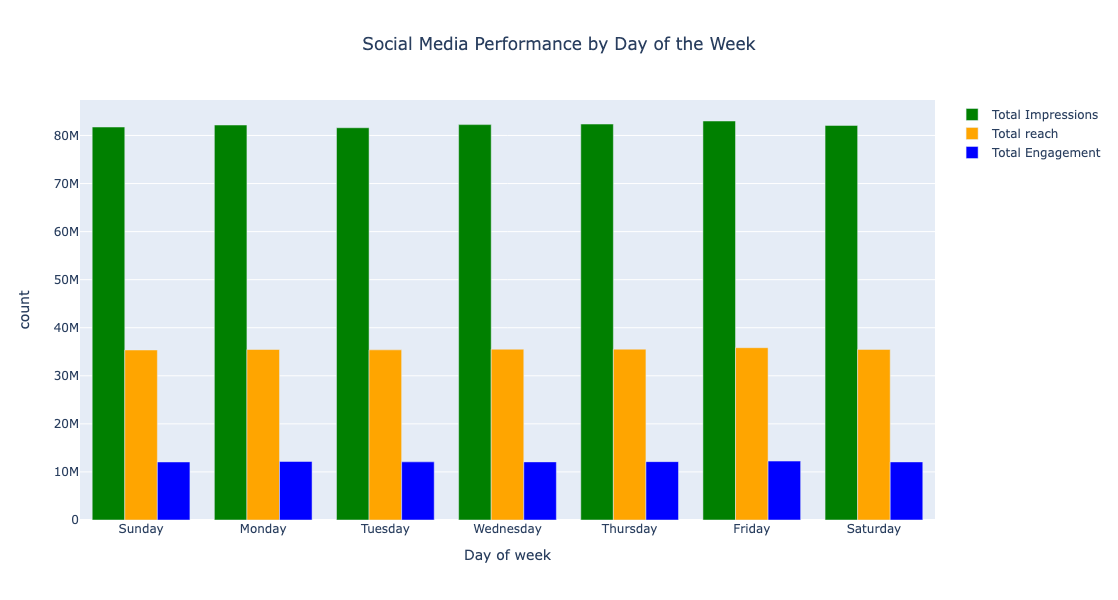

In [146]:
query = """
            SELECT "day_of_week", 
            SUM("Impressions") as "Total Impressions",
            SUM("Reach") as "Total reach",
            SUM("Likes" + "Comments" + "Shares") as "Total Engagement"
        FROM social
        GROUP BY "day_of_week"
        ORDER BY 
            CASE "day_of_week"
                WHEN 'Sunday' THEN 1
                WHEN 'Monday' THEN 2
                WHEN 'Tuesday' THEN 3
                WHEN 'Wednesday' THEN 4
                WHEN 'Thursday' THEN 5
                WHEN 'Friday' THEN 6
                WHEN 'Saturday' THEN 7
            END;
                    """

df = pd.read_sql_query(query, engine)

fig = go.Figure()
fig.update_layout(width=1000, height=600)
fig.add_trace(go.Bar
              (x=df['day_of_week'], 
               y=df['Total Impressions'] , 
               name='Total Impressions' , 
               marker_color= 'green'
              ))

fig.add_trace(go.Bar
              (x=df['day_of_week'], 
               y=df['Total reach'] , 
               name='Total reach' , 
               marker_color= 'orange'))

fig.add_trace(go.Bar
              (x=df['day_of_week'], 
               y=df['Total Engagement'] , 
               name='Total Engagement' , 
               marker_color= 'blue'))

fig.update_layout(
    title='Social Media Performance by Day of the Week' ,
    barmode='group',
    xaxis_title='Day of week',
    yaxis_title='count',
    title_x = 0.5 ,
    hoverlabel=dict(bgcolor="black", font=dict(color="white"))
)

fig.show()



####  It indicates that Friday has the highest total impressions and reach followed closely by Thursday and Wednesday. This suggests that content posted on Fridays tends to perform better in terms of visibility and reach compared to other days of the week.

&nbsp;
&nbsp;


&nbsp;
&nbsp;


In [152]:
pd.read_sql_query( """
            select "Audience Gender" , sum("Impressions") as "Total Impression", sum("Reach") as "Total Reach" , 
            sum("Likes" + "Comments" + "Shares") as "Total Engagement"
            from social
            group by 1
            order by 4 desc
            """, engine
                 )

,Audience Gender,Total Impression,Total Reach,Total Engagement
0,Male,192357620.0,83137151.0,28425909.0
1,Female,192732946.0,83250532.0,28278695.0
2,Other,190176697.0,82259958.0,28216791.0


#### Results shows that female are the one who get served most of post also they are the most numbers of new  users , but when it comes to engagement 'Male' do highest interaction with post .

&nbsp;
&nbsp;

&nbsp;
&nbsp;

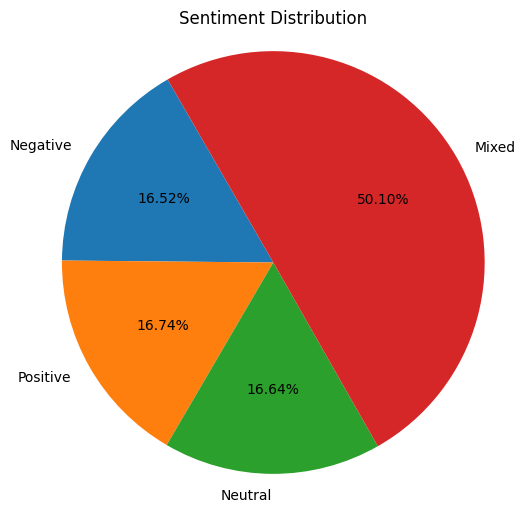

In [179]:
query = """
            select  "Sentiment", 
            count(*) as "Count of Sentiment"
           from social
           group by 1
           """
df = pd.read_sql_query(query, engine)
plt.figure(figsize=(6, 6))
plt.pie(df['Count of Sentiment'], labels=df['Sentiment'], autopct='%1.2f%%', startangle=120)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

&nbsp;
&nbsp;

In [208]:
pd.read_sql_query("""
                 select "Audience Location", sum("Likes" + "Comments" + "Shares") as "Total engagement" ,
                sum("Reach") as "Total reach" ,
                sum("Impressions") as "Total impressions"
                from social
                group by 1
                order by 4 desc
                limit 5""",
                  engine)

,Audience Location,Total engagement,Total reach,Total impressions
0,Korea,674283.0,2039032.0,4825991.0
1,Congo,659889.0,1963739.0,4472015.0
2,Uzbekistan,391341.0,1134145.0,2705185.0
3,Dominica,371649.0,1175462.0,2679669.0
4,Bouvet Island (Bouvetoya),393559.0,1122732.0,2647697.0


##### It appears that "Korea" is the top-performing country in terms of total engagement, total reach, and total impressions. This suggests that content targeting the audience in Korea has performed exceptionally well compared to other countries.

&nbsp;
&nbsp;

In [193]:
pd.read_sql_query("""
                    select "Audience Continent" ,
                    sum("Likes" + "Comments" + "Shares") as "Total Engagement" ,
                    sum("Reach") as "Total Reach",
                    sum("Impressions") as "Total Impressions"
                  from social
                  group by 1
                  order by 4 desc
                  """,engine)

,Audience Continent,Total Engagement,Total Reach,Total Impressions
0,Africa,20737660.0,60946192.0,140210539.0
1,Europe,17362207.0,50451673.0,117679939.0
2,Asia,17261122.0,50817503.0,117259885.0
3,NorthAmerica,13428113.0,39648814.0,91459772.0
4,Oceania,10086182.0,29268766.0,67897855.0
5,SouthAmerica,5297161.0,15300222.0,35767247.0
6,Antarctica,748950.0,2214471.0,4992026.0


##### We can conclude that Africa is the top-performing continent in terms of audience engagement, reach, and impression count. This suggests that the content resonates strongly with the audience in Africa, leading to significant levels of interaction, broad reach, and high visibility.

&nbsp;
&nbsp;

### Quick Recap
- people ofter engaged with post by 'likes'.
- Impressions, Reach and Engagement increasing each year .
- LinkedIn's effectiveness in content distribution and Twitter's dominance in reaching a large number of unique users.
- Video content outperforms both image and link content in terms of impressions, reach, and engagement
- The senior adult demographic constitutes the largest portion of viewers.
- Impressions peak during the Night time period across all platforms.
- Dip in social media activity during the year-end transition, possibly influenced by holidays, marketing changes, or shifts in user           behavior.
- Females receive the most posts and make up the majority of new users, while males engage the most with posts.
- The majority of social media posts are categorized as having a mixed sentiment.
- Korea leads in Impressions, reach, and engagement at the country level, while Africa dominates at the continent level.
- Friday has the highest total impressions and reach